In [2]:
import tensorflow as tf

In [3]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [4]:
(train_images,train_labels),(_,_)=tf.keras.datasets.mnist.load_data()

print(type(train_images))
train_images=np.expand_dims(train_images, axis=-1)
train_images=train_images.astype('float32')

train_images=(train_images-127.5)/127.5



<class 'numpy.ndarray'>


In [5]:
BATCH_SIZE=256
BUFFER_SIZE=train_images.shape[0]

In [6]:
train_dataset=tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size=BUFFER_SIZE).batch(BATCH_SIZE)

In [7]:
def generator_model():
    model=tf.keras.Sequential()
    model.add(layers.Dense(7*7*256,use_bias=False,input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7,7,256)))

    model.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding='same',use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding='same',use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1,(5,5),strides=(2,2),padding='same',use_bias=False,activation='tanh'))

    return model

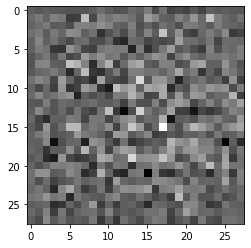

In [10]:
gen=generator_model()
noise=tf.random.normal([1,100])
generated_im=gen(noise,training=False)

plt.imshow(generated_im[0,:,:,0],cmap="gray")